<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification</span> (Manning Publications)<br/>by <em>Daniel Buscombe</em></strong><br/><br/>
        <strong>> Chapter 1: Deliverable Partial Solution </strong><br/>
    </p>  

The first thing to do is to import the required libraries. We will need ```tensorflow```, ```rasterio```, ```requests``` (or ```wget```, whatever you prefer using to download a file from the web using Python) and the ```io``` package from ```scikit-image```

In [3]:
!pip install tensorflow
!pip install rasterio
!pip install wget


In [29]:
import tensorflow as tf
import rasterio
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

Download an image from the Sentinel2 dataset.

In [5]:
!wget https://lp-prod-resources.s3.us-west-2.amazonaws.com/106/example_TCI_10m.jp2

--2023-08-03 11:51:59--  https://lp-prod-resources.s3.us-west-2.amazonaws.com/106/example_TCI_10m.jp2
Resolving lp-prod-resources.s3.us-west-2.amazonaws.com (lp-prod-resources.s3.us-west-2.amazonaws.com)... 52.92.180.10, 52.218.243.81, 3.5.79.17, ...
Connecting to lp-prod-resources.s3.us-west-2.amazonaws.com (lp-prod-resources.s3.us-west-2.amazonaws.com)|52.92.180.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135223654 (129M) [application/x-www-form-urlencoded]
Saving to: ‘example_TCI_10m.jp2’

example_TCI_10m.jp2 100%[===================>] 128.96M  42.1MB/s    in 3.1s    

2023-08-03 11:52:03 (42.1 MB/s) - ‘example_TCI_10m.jp2’ saved [135223654/135223654]



### get the profile of the file.
It has information like driver, dimentions, crs data, etc.
The function has the side effect of creating a dataset with a profile property we can use later.

In [7]:
with rasterio.open('example_TCI_10m.jp2', driver='JP2OpenJPEG') as dataset:
    array = dataset.read(1)
    print(dataset.profile)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32642), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4700040.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


Create three ```TIFF``` images, using the same function ```write_image``` as in the previous notebook:

In [8]:
def write_image(input, output, band):
    with rasterio.open(input, driver='JP2OpenJPEG') as src_dataset:

        array = src_dataset.read(band)
        # Get a copy of the source dataset's profile. Thus our
        # destination dataset will have the same dimensions,
        # number of bands, data type, and georeferencing as the
        # source dataset.
        kwds = src_dataset.profile

        # Change the format driver for the destination dataset to
        # 'GTiff', short for GeoTIFF.
        kwds['driver'] = 'GTiff'

        # Add GeoTIFF-specific keyword arguments.
        kwds['tiled'] = True
        kwds['blockxsize'] = 256
        kwds['blockysize'] = 256
        kwds['photometric'] = 'YCbCr'
        kwds['compress'] = 'JPEG'

        with rasterio.open(output, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write(array.astype(rasterio.uint8), 1)

In [9]:
# files we will use for the three bands
file_list = ['r1.tif', 'r2.tif', 'r3.tif']

# create one image for each band
[write_image('example_TCI_10m.jp2',f, band) for f,band in zip(file_list, [1,2,3])]


[None, None, None]

In [12]:
# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

We will now use only the first image we created. We read it using ```imread``` from ```scikit-image``` and display its dimensions

##### skimage.io.imread(fname, as_gray=False, plugin=None, **plugin_args)

In [33]:
# experment with the full stack
# img = skimage.io.imread('stack.tif')

img = skimage.io.imread('r1.tif')

In [34]:
# examine what we have for sanity check
print(type(img))
img.ndim

<class 'numpy.ndarray'>


3

The image is indeed huge! It has 3 color channels and is 10980 pixels in both veritcal and horizontal dimenstion. We will use ```tf.image``` to rescale it to a smaller image

In [35]:
# use tensorflow to resize image
img_small = tf.image.resize(img, [5000, 5000])

... then we will also rotate the image 90 degrees and store the rotated version in a new variable

In [36]:
# use tensorflow to rotate small image
img_r = tf.image.rot90(img_small)

ReADY to display the result. The visual results allow us to be confident that...
* we only presented one band of color
* we rotated the image

The value of reducing the size is not so clear. I was able to present the image at 10000 x 10000 with all 3 bands. The delay was tiny.



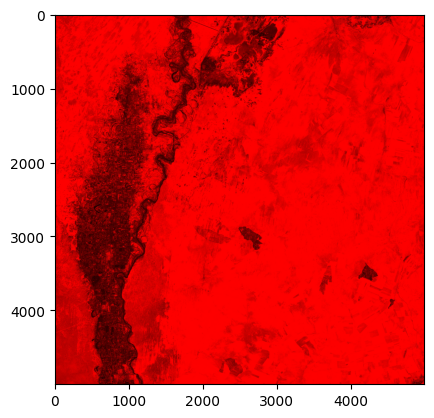

In [41]:
# show small image w/o rotation
plt.imshow(img_small.numpy().astype('uint8'), cmap='gray')

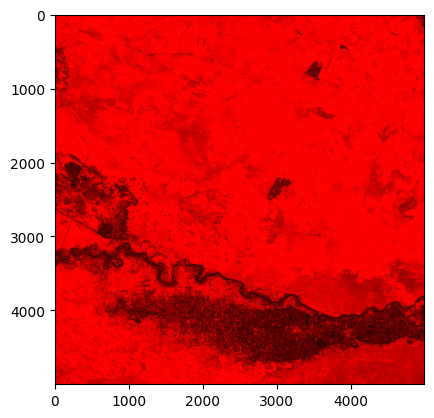

In [42]:
# show small image with rotation
plt.imshow(img_r.numpy().astype('uint8'), cmap='gray')